# A recommendation system of scientific publications on physics

### The primary goal of this project is to analyze the titles of academic publications on physics, and develop an item-based recommendation system using Word2Vec, where a list of publications similar to a query title will be returned.

**Data Source**: Elsevier Scopus API. ~200k physics publications were collected and saved in PostgreSQL.

In [6]:
import os

In [7]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
#concurrency
import multiprocessing
#regex
import glob
import re
import nltk
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold

In [9]:
os.chdir('../data/analyzed/')

<h3 style="color:darkred">Preprocessing</h3>

In [10]:
# Load the data
titlesDF = pd.read_csv('titlesInfo.csv', header=0, encoding='ISO-8859-1')

In [11]:
titlesDF.shape

(194834, 6)

In [12]:
titlesDF.dtypes

title            object
journal          object
cover_date       object
citedby_count     int64
cleaned_title    object
compounds        object
dtype: object

 There are 194834 articles.
 The meanings of the columns are:
 1. "*title*": the title of the article, *string*
 2. "*journal*": the journal that the article is published, *string*
 3. "*cover_date*": the date that the article is published, *date YYYY-MM-DD*
 4. "*citedby_count*": the number of other articles that cite this one, *integer*
 5. "*cleaned_title*": the cleaned title, where all compositions in the molecular formula are removed.
 6. "*compounds*": what chemical compounds/elements are involved in the article, *string*, expressed as A,B,C

The values of the first four columns were extracted from the raw data retrieved from Elsevier API. For the last two columns, *isTheory* was determined based on a keyword search, while *compounds* were extracted using regex. These were done with Spark on Databricks, and the details could be found at `http://www.yufeil.com/tedatabricksnotebook.html`

In [13]:
titlesDF = titlesDF[pd.notnull(titlesDF['cleaned_title'])]

In [14]:
# Fill the missing data in the titles and compounds with emtpy string.
titlesDF['cleaned_title'].fillna('', inplace=True)
titlesDF['compounds'].fillna('', inplace=True)

titlesDF.head()

,title,journal,cover_date,citedby_count,cleaned_title,compounds
0,The Role of Interfacial Reactions in Determini...,Plasma Chemistry and Plasma Processing,2016-11-01,1,The Role of Interfacial Reactions in Determini...,
1,Modulation of the domain mode in GaN-based pla...,Physica Status Solidi (C) Current Topics in So...,2016-05-01,2,Modulation of the domain mode in GaN-based pla...,GaN
2,Fabrication of Tiron-TiO<inf>2</inf> charge-tr...,Materials Chemistry and Physics,2016-12-01,1,Fabrication of Tiron-TiO2 charge-transfer comp...,TiO
3,Tunable VO<inf>2</inf>/Au hyperbolic metamaterial,Applied Physics Letters,2016-08-08,3,Tunable VO2/Au hyperbolic metamaterial,"VO,Au"
4,A Hydrogen-Bonded-Supramolecular-Polymer-Based...,Advanced Functional Materials,2016-08-09,11,A Hydrogen-Bonded-Supramolecular-Polymer-Based...,


In [15]:
corpus_raw = u""
with open('titles.txt', 'a', encoding='utf-8') as f:
    for i in range(titlesDF.shape[0]):
        line = titlesDF.loc[i, 'cleaned_title']
        corpus_raw += line + '. '
        f.write(line + '\n')

In [16]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [17]:
# Tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [18]:
# Convert string to words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z0-9]", " ", raw)
    words = clean.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w)>3]
    if len(words) > 0:
        words[0] = words[0].lower() # Here we only make the first word to lower case, to avoid lower_case the molecular formulae.
        
    return words

In [19]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        s = sentence_to_wordlist(raw_sentence)
        if s:
            sentences.append(s)

In [20]:
len(sentences)

198693

In [21]:
token_count = sum([len(sentence) for sentence in sentences])
print(token_count)

1650000


There are totally 198693 sentences/titles, and 1650k words.

Let's implement bigram, so that phrases such as charge_transfer, quantum_dot can be captured.

In [22]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

phrases = Phrases(sentences)
bigram = Phraser(phrases)

In [23]:
import pickle
pickle.dump(bigram, open("bigram.p", "wb"))

In [24]:
sentences_bigram = list(bigram[sentences])

<h3 style="color:darkred">Word2Vec</h3>

In this section, we will perform Word2Vec to the titles we have. It is a model introduced by Google at 2013. A good tutorial can be found at https://www.youtube.com/watch?v=ERibwqs9p38 and https://www.youtube.com/watch?v=pY9EwZ02sXU. Basically, we'd like to project every word to a *topic* space. The number of topics needs to be pre-defined, but we don't need to label them. So it is a unsupervised learning. 

Here is several pictures that illustrate Word2Vec (from Tensorflow).

<img src='https://www.tensorflow.org/images/linear-relationships.png'>

The package we use here is gensim.

Parameters definition:

In [25]:
# Dimensionality of the word vectors
num_features = 25

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 5

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for RNG
seed = 1

In [26]:
# Use gensim Word2Vec model
titles2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [27]:
titles2vec.build_vocab(sentences_bigram)

In [28]:
len(titles2vec.wv.vocab)

31070

Train the sentences

In [29]:
titles2vec.train(sentences_bigram, total_examples=titles2vec.corpus_count, epochs=titles2vec.iter)

6589937

In [30]:
# Save the model
titles2vec.save("titles2vec_25.w2v")

Let's explore the model we trained.

In [31]:
titles2vec = w2v.Word2Vec.load("titles2vec_25.w2v")

In this model, each word in the vocabulary is represented by a 25 dimensional (recall that we defined *num_features = 25*) vector. To visualize it, we can reduce the vector space to 2-dimensional. The dimension reduction method we use here is *t stochastic neighbor embedding* 

In [32]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = titles2vec.wv.syn0

# Train t-SNE
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

Plot!

In [33]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[titles2vec.wv.vocab[word].index])
            for word in titles2vec.wv.vocab
        ]
    ],
    columns = ["word", "x", "y"]
)

In [34]:
points.head(10)

,word,x,y
0,role,31.650820,4.546355
1,Interfacial,-64.504448,17.091301
2,Reactions,-66.640404,17.632700
3,Determining,-42.508698,1.699883
4,Plasma,-64.686195,18.571123
5,Liquid,-64.457993,17.974180
6,Chemistry,-60.302265,18.752342
7,modulation,36.147186,39.313686
8,domain,42.252140,17.501673
9,mode,26.153801,47.073952


In [35]:
# Save points
points.to_csv('w2v_points.csv',index=False)

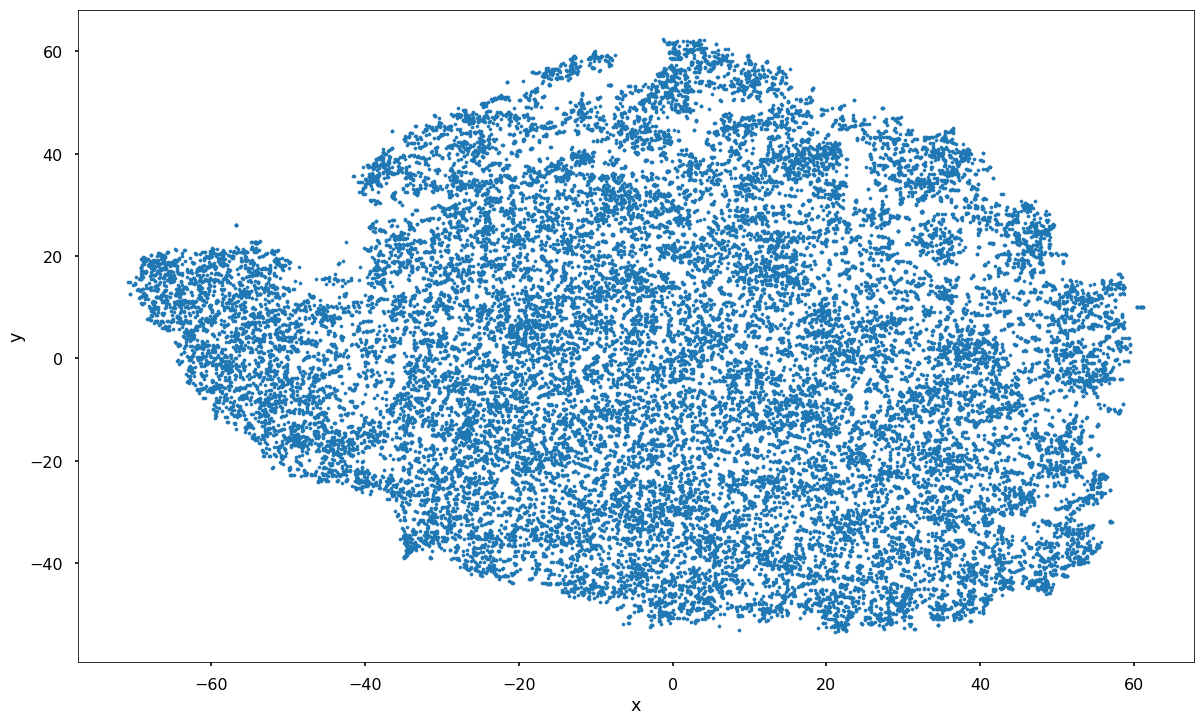

In [36]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

The plot shows the 2D representation of all words in the vocabulary. Here the closer two words are, the more similar they are. Let's zoom in to see some interesting regions.

In [37]:
# Plot zoomed regions
def plot_region(x_bounds, y_bounds):
    #print(points.shape)
    s = points[ (points['x'] >= x_bounds[0]) & (points['x'] <= x_bounds[1])] 
    #print(s.shape)
    s = s[(s['y'] >= y_bounds[0]) & (s['y'] <= y_bounds[1])]
    #print(s.shape)
    #print(s.head())
    ax = s.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in s.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [38]:
# Give a query word, plot the words nearby
def plot_nearby(word,side_len=4):
    if side_len <= 0:
        print('side_len should be greater than zero!')
        return
    try:
        coordinates = points[points['word']==word].reset_index()
        x, y = coordinates.loc[0,'x'], coordinates.loc[0,'y']
        x1, x2, y1, y2 = x-side_len/2, x+side_len/2, y-side_len/2, y+side_len/2
        plot_region(x_bounds=(x1,x2), y_bounds=(y1,y2))
    except Exception as e:
        print('---------------------Cannot find {} in the vocabulary----------------'.format(word))

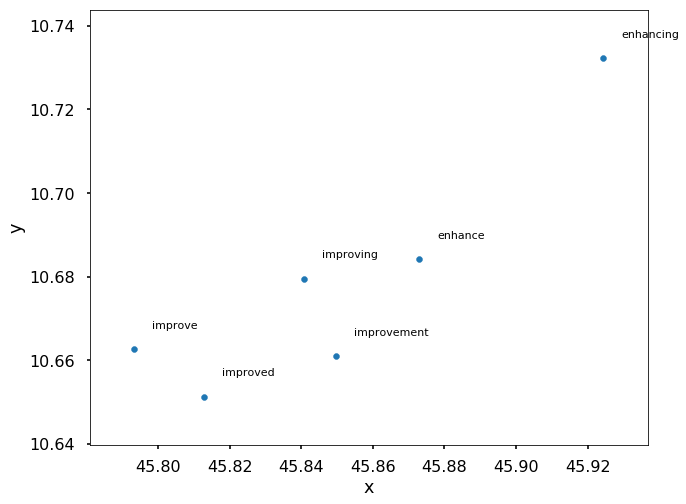

In [50]:
plot_nearby('enhance',1)

The words in this region are indeed related to *enhance*.

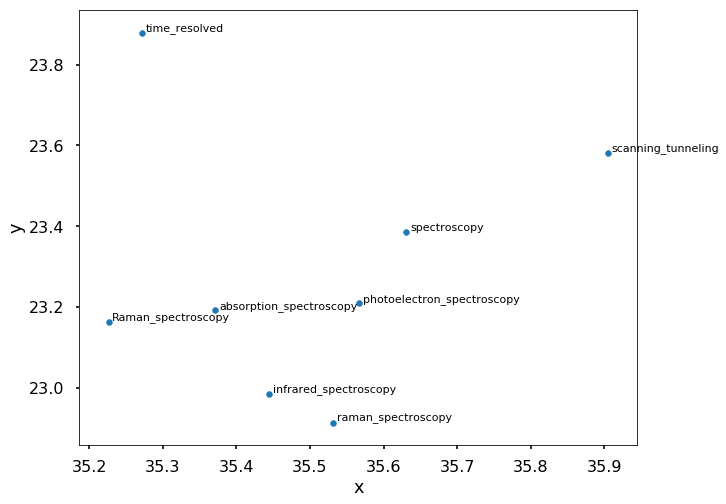

In [51]:
plot_nearby('spectroscopy',1)

This plot is about different spectroscopy techniques.

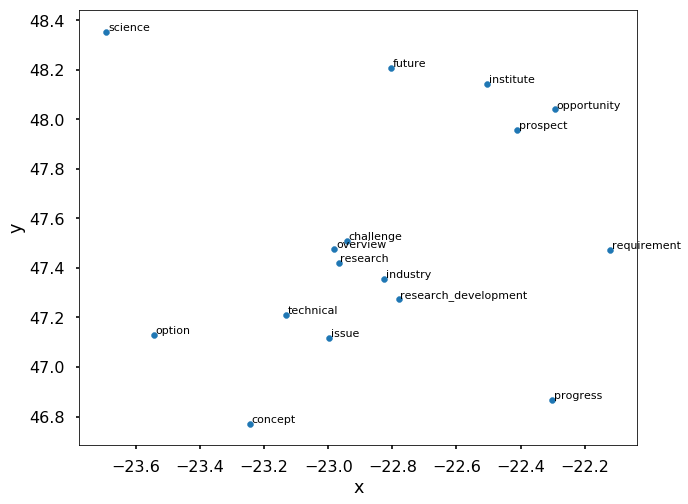

In [53]:
plot_nearby('overview',2)

The words in this region are indeed close to "*overview*".

Spark plasma sintering is a popular technique in thermoelectric research. It densifies powder into a pellet via applying pressure at both side. So this list makes sense.

<h3 style="color:darkred">Building an item-based recommendation system</h3>

We can build an item-based recommendation system for the articles, based on the similarity between titles. In the future I'll also try to implement a more complex recommendation system, where the authors are considered as users, and articles are items.

First let's figure out a way to calculate how similar two articles are.

We can treat the titles as bag-of-words, and since we already projected each word to a 25 dimensional space, we can simply take the sum of them, and represent each title as a 25-dimensional vector.

In [42]:
# Convert title to vector
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def title_to_vec(title, model=titles2vec, dim=25, stop_words=stop_words):
    result = np.zeros(dim)
    words = word_tokenize(title)
    try:
        words[0] = words[0].lower()
    except Exception as e:
        pass
    words = ' '.join(words)
    words = bigram[words.split()]
    words = [w for w in words if w not in stop_words and w not in r':-.,']
    
    for word in words:
        if word in model.wv.vocab:
            w2v = model.wv[word]
            result += w2v
    
    return result

With the function above, we can convert titles to vectors

In [43]:
titlesDF['title_vec'] = titlesDF['cleaned_title'].apply(lambda x: title_to_vec(x, titles2vec))

In [44]:
titlesDF['title_vec'][:5]

0    [4.27966853976, 7.77533096075, -1.6404183805, ...
1    [-1.61190826073, 1.3024119921, -3.52903312445,...
2    [0.340547978878, 1.94369304925, -0.32199822855...
3    [-0.272351235151, -0.1611424312, -0.8702988326...
4    [1.91571515799, 4.56500738859, -1.33283573389,...
Name: title_vec, dtype: object

Now each title is associated with a 25 vector. So given any new title, we can calculate the most similar titles to it. Here we use *cosine similarity*.

In [45]:
def cos_sim(v1, v2):
    """ Returns a custmized cosine similarity of two vectors"""
    norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
    norm_product = norm1 * norm2
    if norm_product == 0:
        return 0
    
    # It is found that the vallina cosine similarity doesn't do
    # a good job, partially due to the fact that it ignores the
    # difference between the lengths of the two vectors. Here I
    # try to add a pre-factor to the original cos_sim to repre-
    # sent the difference between two lengths.
    norm_ratio = min(norm1, norm2) / max(norm1, norm2)
    
    return np.dot(v1, v2) * np.sqrt(norm_ratio) / norm_product

In [46]:
def clean_title(title, stop_words=stop_words):
    # To do: convert molecular formula
    words = word_tokenize(title)
    try:
        words[0] = words[0].lower()
    except Exception as e:
        pass
    words = ' '.join(words)
    words = bigram[words.split()]
    return " ".join([w for w in words if w not in stop_words and w not in r':-.,'])

In [47]:
def get_most_similar_title(new_title, titlesDF, model, dim=25, k=1):
    """ Returns the k most similar titles to the new_title"""
    new_title = clean_title(new_title)
    new_vec = title_to_vec(new_title, model, dim)
    sim_list = titlesDF[titlesDF['title'] != '']['title_vec'].apply(lambda x: cos_sim(new_vec, x)).values
    
    # Plot distribution of cos_sim_list
    plt.hist(sim_list, bins=50)
    plt.xlabel('Similarity')
    plt.ylabel('Count')
    plt.title('Distribution of Similarities')
    plt.show()
    
    indices = find_topk_indices(sim_list, k)
    
    similar_titles = [titlesDF.loc[i, 'title'] for i in indices]
    
    print("Cleaned Title: " + new_title)
    print('Similar Articles:\n')
    for i, title in enumerate(similar_titles):
        print('('+str(i+1)+')  '+title+'\n')
    
    return similar_titles

def find_topk_indices(s, k):
    # Return the indices of the largest k elements, ordered by their values.
    from heapq import heappush, heappop
    res = []
    for i, n in enumerate(s):
        if not res or len(res) < k or res[0][0] < n:
            heappush(res, (n,i))
        if len(res) > k:
            heappop(res)
    return [i for n, i in sorted(res, reverse=True)]
            

With the functions above, we can build a model to return a list of similar publications to the query title.

I deployed the model on Heroku. http://paperflask.herokuapp.com/

Future works:
1. Optimize the word2vec model. Implement stemming and lemmatization
2. Further improve the recommendation system. For example, take authors into consideration.
3. Build a model to automatically generate titles
4. Analyze the network among authors